<a href="https://colab.research.google.com/github/lennartmueller123/academicpages.github.io/blob/master/LSTM_application_in_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikeras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
import yfinance as yf

In [ ]:
# Function to create a dataset with sliding window validation
def create_dataset_sliding_window(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

In [ ]:
# Function to create an LSTM model
def create_lstm_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=units))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
# Download historical stock data using yfinance
symbol = 'GOOGL'
start_date = '2020-01-01'
end_date = '2023-01-01'
stock_data = yf.download(symbol, start=start_date, end=end_date)

# Extract 'Close' prices
closing_prices = stock_data['Close'].values.reshape(-1, 1)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices)

# Split the data into training and testing sets using sliding window validation
train_size = int(len(closing_prices_scaled) * 0.8)  # 80% for training
test_size = len(closing_prices_scaled) - train_size

train, test = closing_prices_scaled[0:train_size], closing_prices_scaled[train_size:len(closing_prices_scaled)]

# Create the dataset with time steps for training and testing using sliding window
time_steps = 10  # adjust as needed
X_train, y_train = create_dataset_sliding_window(train, time_steps)
X_test, y_test = create_dataset_sliding_window(test, time_steps)

# Reshape the input data to be 3-dimensional [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from scikeras.wrappers import KerasRegressor

# Define the LSTM model
def create_lstm_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=units))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Wrap the model using KerasRegressor
model = KerasRegressor(model=create_lstm_model, verbose=0)

# Define the parameter grid
param_grid = {
    'model__units': [50, 100],
    'model__optimizer': ['adam', 'rmsprop'],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found: ", grid_result.best_params_)

# Get the best model
best_model = grid_result.best_estimator_.model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Best parameters found:  {'batch_size': 32, 'epochs': 100, 'model__optimizer': 'adam', 'model__units': 100}


In [ ]:
# Predictions
best_model_instance = create_lstm_model(**grid_result.best_params_.get('model', {}))
best_model_instance.fit(X_train, y_train, **{k: v for k, v in grid_result.best_params_.items() if k not in ['model__units', 'model__optimizer']})

train_predict = best_model_instance.predict(X_train)
test_predict = best_model_instance.predict(X_test)

# Inverse transform the predicted prices to the original scale
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1483
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0094
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0014
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0014
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - lo

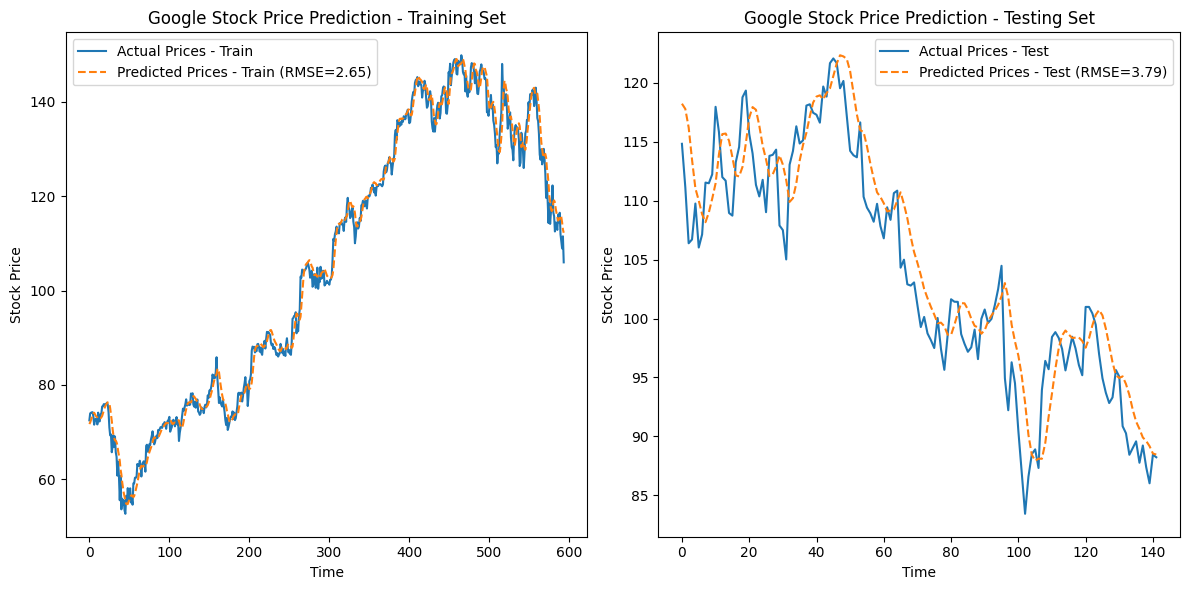

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(y_train.flatten(), label='Actual Prices - Train')
plt.plot(train_predict.flatten(), label=f'Predicted Prices - Train (RMSE={train_rmse:.2f})', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Google Stock Price Prediction - Training Set')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test.flatten(), label='Actual Prices - Test')
plt.plot(test_predict.flatten(), label=f'Predicted Prices - Test (RMSE={test_rmse:.2f})', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Google Stock Price Prediction - Testing Set')
plt.legend()

plt.tight_layout()
plt.show()
